# Step 1: Setup

In [47]:
# Connect the drive with google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
from google.colab import userdata
api_key = userdata.get("OPENAI")

In [49]:
# Install the packages we will need
!pip install ultralytics
!pip install TTS
!pip install gradio
!pip install transformers sentece-transformers nltk yake
nltk.download("punkt")
nltk.download("punkt_tab")
!pip install gtts

ERROR: Could not find a version that satisfies the requirement sentece-transformers (from versions: none)
ERROR: No matching distribution found for sentece-transformers


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [50]:
# Import all the libraries
from ultralytics import YOLO
import cv2
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from diffusers import StableDiffusionPipeline
from TTS.api import TTS
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import gradio as gr
from openai import OpenAI
from IPython.display import display, Markdown, Audio
import nltk
from nltk.tokenize import sent_tokenize
from gtts import gTTS
import random

# Step 2: Object Detection model to detect the objects for our story


0: 448x640 4 persons, 1 dog, 1 chair, 1 couch, 2 potted plants, 2 books, 1 vase, 34.6ms
Speed: 11.6ms preprocess, 34.6ms inference, 7.7ms postprocess per image at shape (1, 3, 448, 640)


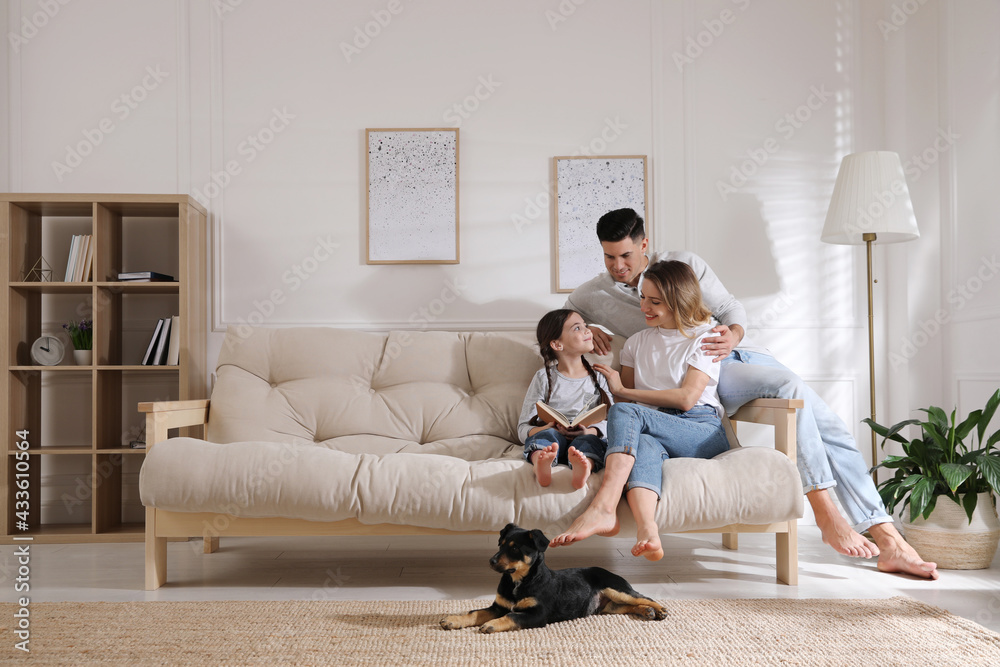

Detected Objects: dog, couch, potted plant, person, person, person, vase, book, book, chair, person, potted plant


In [51]:
# Load the YOLOV8 model
model = YOLO('yolo11s.pt')

# Set the image path
image_path = '/content/family.png'

# From ndarray
image = cv2.imread(image_path)

# Perform object detection on the image
results = model.predict(source=image, conf=0.3)

# Store the detected objects to a list
detected_objects = []
for result in results:
  for box in result.boxes:
    class_id = int(box.cls[0])
    class_name = model.names[class_id]
    detected_objects.append(class_name)

# Show image with the detected objects
img = Image.open(image_path)
display(img)
plt.imshow(img)
plt.axis("off")
plt.title(f"Detected Objects: {', '.join(set(detected_objects))}")
plt.show()

# Print the detected object list
print(f"Detected Objects: {', '.join(detected_objects)}")

# Step 3: NLP Model for Story writing

In [52]:
# Set the OPENAI_API
client = OpenAI(api_key = api_key)

# System and user prompt.
objects = ['laptop', 'chair', 'desk'] # Example, with detected objects

# Prompt system
system_prompt = """You are a witty and creative writer who crafts smart, lighthearted, and visually engaging real-life stories.
Your goal is to create concise yet vivid narratives that are fun, charming, and easy to capture in images. Focus on key moments,
using clever humor and playful storytelling to leave readers with a pleasant and delightful feeling. Keep the details minimal but
meaningful, ensuring each scene is clear and visually expressive."""

# User prompt
user_prompt = f"""Create a mesmerizing story that includes the following objects: {', '.join(objects)}. The story should be imaginative, emotionally engaging,
and filled with vivid details. Ensure a strong beginning, an intriguing middle, and a memorable ending. The story must strictly contain up to 150 words.
The story begins with:"""

# Call the llm
completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": user_prompt
        }
    ]
)
story = completion.choices[0].message.content

# Display story
display_story = display(Markdown(story))
display_story

In a small, sunlit room, a vintage wooden desk stood proudly, crammed with the clutter of dreams. A laptop rested atop it, its screen glowing like a beacon, revealing a world of imagination. The chair—a quirky, mismatched piece upholstered in an explosion of colors—invited both fatigue and inspiration.

One fateful afternoon, sparks flew as the writer, cradled in the chair's embrace, typed feverishly. Each keystroke transformed mundane thoughts into wild adventures. The laptop whirred happily, like a butterfly taking flight, as characters danced from the screen—heroes, villains, and everything in between.

But just as the plot thickened, a sudden silence fell. The laptop flickered one last time, then dimmed. The chair squeaked in protest, as if urging the writer onward. Unfazed, they closed the laptop and gazed out a nearby window—the real world, after all, was the most enchanting story of all. And life awaited, with endless chapters to explore.

# Step 3: Extraction of Important Scenes with Summarization

In [53]:
# Load the model for summarization
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Summary the story
summary = summarizer(story, max_length=100, do_sample=False)[0]['summary_text']

# Display the summarization
print(f"Story summarization: {summary}")

# Split the story into scenes
scenes = sent_tokenize(summary)

# Prepare our prompt for the diffusion model
prompts = [f"Highly detailed, cinematic scene: {scene}, digital art, 4K, realistic lighting" for scene in scenes]
print("🔹 Prompts:\n", prompts)

Device set to use cuda:0


Story summarization: A writer sat in a mismatched chair and typed feverishly on a laptop. As the plot thickened, a sudden silence fell. The laptop flickered one last time, then dimmed. Unfazed, they closed the laptop and gazed out a nearby window. The real world awaited, with endless chapters to explore.
🔹 Prompts:
 ['Highly detailed, cinematic scene: A writer sat in a mismatched chair and typed feverishly on a laptop., digital art, 4K, realistic lighting', 'Highly detailed, cinematic scene: As the plot thickened, a sudden silence fell., digital art, 4K, realistic lighting', 'Highly detailed, cinematic scene: The laptop flickered one last time, then dimmed., digital art, 4K, realistic lighting', 'Highly detailed, cinematic scene: Unfazed, they closed the laptop and gazed out a nearby window., digital art, 4K, realistic lighting', 'Highly detailed, cinematic scene: The real world awaited, with endless chapters to explore., digital art, 4K, realistic lighting']


# Step 4: Diffusion Model for images

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

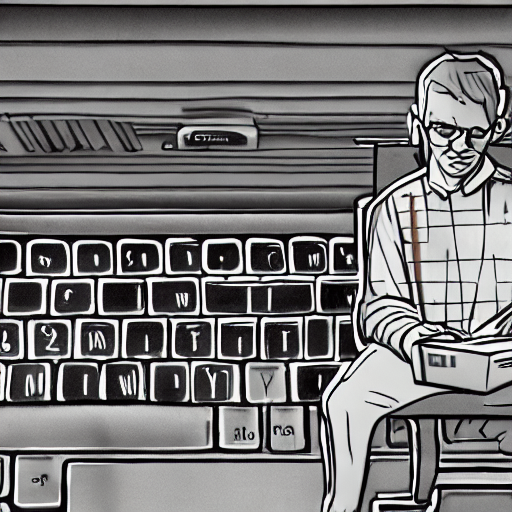

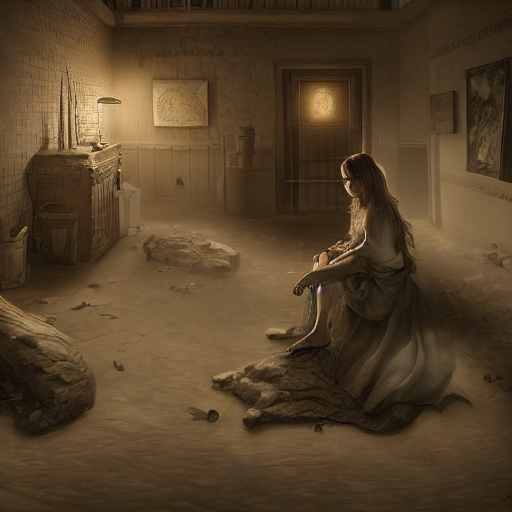

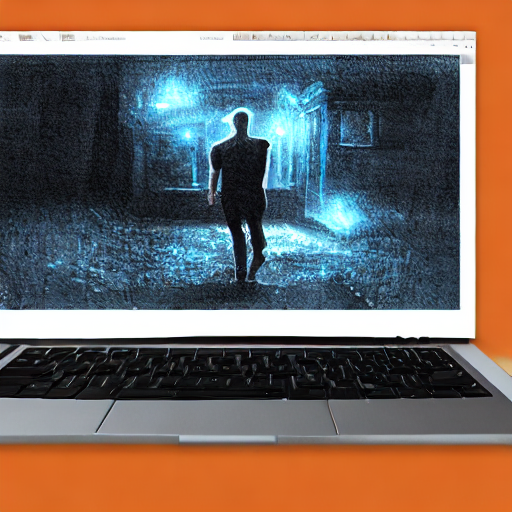

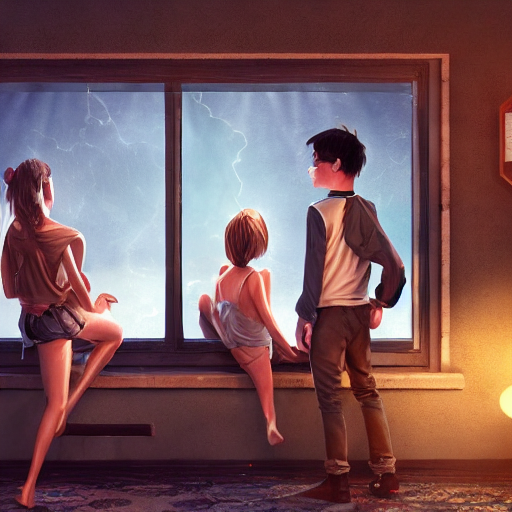

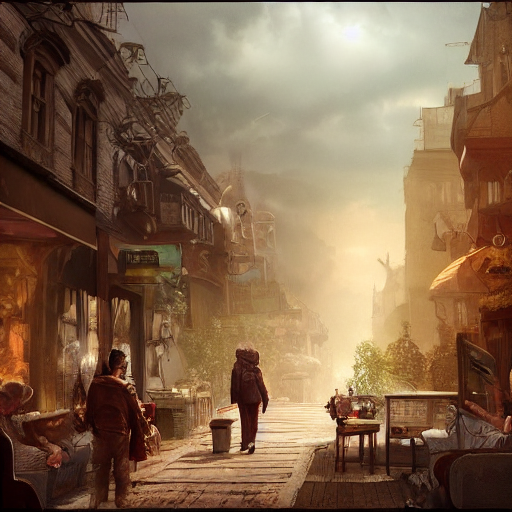

In [54]:
# Load the diffusion model
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")


images = [] # a list to save the images

# Loop throught the scenes
for prompt in prompts:
  image = pipe(prompt).images[0] # Creates the image
  images.append(image)
  image.save(f"scene_{prompt.index(prompt) +1}.png") # Save the image

# Display images
for img in images:
  display(img)

# Step 5 Text-to-Speech(Google TTS)

In [55]:
# Set the text
tts = gTTS(text=story, lang='en', slow=False)

# Save the mp3 file
audio_file_path = 'story_tts.mp3'
tts.save(audio_file_path)

# Display the audio
Audio(audio_file_path, autoplay=True)

# Alternative ElevenLabs API (Paid way)

In [56]:
# Eleven Labs API
# !pip install elevenlabs
# !apt-get update && apt-get install -y mpv
# import os
# from elevenlabs import ElevenLabs, stream
# from IPython.display import Audio
# from google.colab import userdata
# eleven_api_key = userdata.get("ELEVEN_LABS")

# client = ElevenLabs(api_key = eleven_api_key)

# audio_stream = client.text_to_speech.convert_as_stream(
#     text = story,
#     voice_id = 'EXAVITQu4vr4xnSDxMaL',
#     model_id = 'eleven_multilingual_v2'
# )

# # Save the file as MP3
# audio_file_path = "story_streamed.mp3"

# with open(audio_file_path, "wb") as f:
#     for chunk in audio_stream:
#         if isinstance(chunk, bytes):
#             f.write(chunk)

# # Display the audo
# Audio(audio_file_path, autoplay=True)

# Step 6: Mixing them all together: Final Pipeline

In [57]:
# Load the models
yolo_model = YOLO("yolov8n.pt")
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda")
client = OpenAI(api_key=api_key)

# 1. Object Detection with YOLOv8
def detect_objects(image_path):
  results = yolo_model(image_path)
  detected_objects = []
  for r in results:
    for box in r.boxes:
      class_id = int(box.cls[0])
      label = yolo_model.names[class_id]
      detected_objects.append(label)
  return detected_objects


# 2. Story Generation with GPT-4o-mini
def generate_story(detected_objects):
  # llm prompt
  story_prompt = f"Write a short story based on the following objects: {', '.join(detected_objects)}"
  # Call the llm
  response = client.chat.completions.create(
      model = "gpt-4o-mini",
      messages = [{"role": "user", "content": story_prompt}],
      max_tokens = 200
  )
  return response.choices[0].message.content

# 3. Split the story into scens for image geneartion
def summarize_story(story):
  #summarization
  summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
  summary = summarizer(story, max_length=100, do_sample=False)[0]['summary_text']
  # Split the story into scenes
  scenes = sent_tokenize(summary)
  return scenes

# 4. Images generator with Stable Diffusion
def generate_images(story):
  # Make the scenes
  scenes = summarize_story(story)
  prompts = [f"Highly detailed, cinematic scene: {scene}, digital art, 4K, realistic lighting" for scene in scenes]
  images = []
  # Loop through the scenes
  for prompt in prompts:
    image = pipe(prompt).images[0] # Creates the image
    images.append(image)
    image.save(f"scene_{prompt.index(prompt) +1}.png") # Save the image

  # Display images
  for img in images:
    display(img)

# 5. Story conversion into Audio with Google TTS
def text_to_speech(story):
  tts = gTTS(text=story, lang="en", slow=False)
  audio_file_path = "story_audio.mp3"
  tts.save(audio_file_path)
  display(Audio(audio_file_path, autoplay=True))

# 6. run_pipeline(image_path)
def storytelling_pipeline(image_path):
    detected_objects = detect_objects(image_path)
    if not detected_objects:
        return "No objects detected. Try another image."

    story = generate_story(detected_objects)
    key_scenes = summarize_story(story)
    images = generate_images(key_scenes)
    audio_path = text_to_speech(story)

    return story, key_scenes, images, audio_path

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [58]:
# 🔹 Deploy with Gradio
def run_interface():
    def gradio_wrapper(image_path):
        story, key_scenes, images, audio_path = storytelling_pipeline(image_path)
        return story, key_scenes, images, Audio(audio_path, autoplay=True)

    demo = gr.Interface(fn=gradio_wrapper, inputs="file", outputs=["text", "text", "gallery", "audio"])
    demo.launch()

# Run Gradio Interface
run_interface()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a0d57b35a5bf400151.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
